Download Iris data.

Divide data on 2 sets (25 samples of each class in set). Classify samples of 2nd set based on data from 1st set. Show classification results in 2D dotten plots on petals and sepala. Compare classification results with facts and estimate classification quality.

# Importing data 

In [1]:
import operator

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

plt.style.use("seaborn")

In [2]:
data = pd.read_csv("../data/iris_data.csv")
display(data)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


# Preparing data 

In [3]:
display(data.describe())

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
# Normalizing data
normalized_data = (data.iloc[:, :4] - data.iloc[:, :4].min())/(data.iloc[:, :4].max() - data.iloc[:, :4].min())
normalized_data["variety"] = data["variety"]

display(normalized_data)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,0.222222,0.625000,0.067797,0.041667,Setosa
1,0.166667,0.416667,0.067797,0.041667,Setosa
2,0.111111,0.500000,0.050847,0.041667,Setosa
3,0.083333,0.458333,0.084746,0.041667,Setosa
4,0.194444,0.666667,0.067797,0.041667,Setosa
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,Virginica
146,0.555556,0.208333,0.677966,0.750000,Virginica
147,0.611111,0.416667,0.711864,0.791667,Virginica
148,0.527778,0.583333,0.745763,0.916667,Virginica


In [5]:
# Splitting data to train and test.
training_data = normalized_data.iloc[:25, :].append(normalized_data.iloc[50:75, :]).append(normalized_data.iloc[100:125, :])
test_data = normalized_data.iloc[25:50, :].append(normalized_data.iloc[75:100, :]).append(normalized_data.iloc[125:, :])

print("Train data: \n{}\n".format(training_data["variety"].value_counts()))
print("Test data: \n{}".format(test_data["variety"].value_counts()))

Train data: 
Virginica     25
Setosa        25
Versicolor    25
Name: variety, dtype: int64

Test data: 
Virginica     25
Setosa        25
Versicolor    25
Name: variety, dtype: int64


# k-nearest neighbors algorithm 

In [6]:
def min_N_values_and_indexes(vec, n=3):
    """Minimal values with indexes.
    """    
    s = sorted(enumerate(vec), key = lambda x: x[1])[:n]
    z_idx, z_value = map(list, zip(*s))
    
    return z_value, z_idx

In [7]:
def d(x, y, p=2):
    """Minkowski distance.
    """
    return (np.sum((np.abs(x - y))**p))**(1 / p)

In [8]:
def kNN(x, Y, k=3):
    """k-nearest neighbors algorithm.
    
    Args:
        x (np.ndarray): vector we want to classify.
        Y (np.ndarray): matrix of vectors we are comparing to.
        k (int): number of neighbours.
    Returns:
        category (str): category of vector x.
    """
    
    distances = []
    
    # Counting distances to all vectors.
    for index, row in Y.iterrows():
        distances.append(d(x[:-1], row[:-1]))
        
    # Finding k min distances with their indexes. 
    min_values, indexes = min_N_values_and_indexes(distances, k)
    
    # Counting votes.
    votes = [1 / (distance + 1e-10) for distance in min_values]
    
    # Making dictionary with categories and votes.
    categories = set(Y["variety"].values)
    zeros = [0 for i in range(3)]
    categories_votes = dict(zip(categories, zeros))
    
    # Filling dictionary.
    for i, vote in enumerate(votes, 0):
        category = Y.iloc[indexes[0], -1]
        current_value = categories_votes.get(category)
        new_value = current_value + vote
        categories_votes[category] = new_value
        
    # Selecting category with maximum value.
    category = max(categories_votes.items(), key=operator.itemgetter(1))[0]
    
    return category

In [9]:
def make_predictions(test_data, training_data, k=3):
    """Making prediction for each sample of test data.
    
    Args:
        test_data (pd.DataFrame): Table with iris data that we make 
                                  predictions for.
        training_data (pd.DataFrame): Table with iris data that we use 
                                      for making predictions.
    Returns:
        predictions (list): List of category prediction for each row.
    """
    
    predictions = []
    
    # Making prediction for each test sample.
    for index, row in test_data.iterrows():
        predictions.append(kNN(row, training_data, k))
        
    return predictions

# Evaluating results 

In [10]:
def metrics(conf_matrix):
    """Calculating metrics.
    
    Returns:
        metrics (np.ndarray): 2D array with prec, rec, f1
                              for each category. Last row 
                              for average values.
    """
    
    metrics = []
    
    # Iteratinig throw each diagonal element.
    for i in range(len(conf_matrix[0])):
        rec = conf_matrix[i, i] / np.sum(conf_matrix, axis=1)[i]
        prec = conf_matrix[i, i] / np.sum(conf_matrix, axis=0)[i]
        f1 = (2 * prec * rec) / (prec + rec)
        metrics.append([prec, rec, f1])
    
    average = np.sum(metrics, axis=0) / len(conf_matrix[0])
    metrics.append(average)    
        
    return metrics

In [11]:
actual_values = test_data["variety"]
predictions = make_predictions(test_data, training_data)

In [12]:
# Defining categories.
categories = list(set(test_data["variety"].values))
print("Categories: \n{}\n".format(categories))

# Defining confusion matrix.
conf_matrix = confusion_matrix(actual_values, predictions, labels=categories)
print("Confusion matrix: \n{}\n".format(conf_matrix))

# Calculating metrics.
metric = metrics(conf_matrix)
print("Metrics: \n{}\n".format(metric))

# Verifying metrics.
report = classification_report(actual_values, predictions, labels=categories)
print("Classification report: \n{}".format(report))

Categories: 
['Versicolor', 'Setosa', 'Virginica']

Confusion matrix: 
[[23  0  2]
 [ 0 25  0]
 [ 5  0 20]]

Metrics: 
[[0.8214285714285714, 0.92, 0.8679245283018867], [1.0, 1.0, 1.0], [0.9090909090909091, 0.8, 0.8510638297872342], array([0.91017316, 0.90666667, 0.90632945])]

Classification report: 
              precision    recall  f1-score   support

  Versicolor       0.82      0.92      0.87        25
      Setosa       1.00      1.00      1.00        25
   Virginica       0.91      0.80      0.85        25

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



# Building plots 

## Initializing methods 

In [13]:
def build_plot(data, plant_type, categories):
    """Building length/width plot on iris data.
    """
   
    plt.figure(figsize=(15, 8))
    colors = ["ro", "bo", "go"]

    for i, category in enumerate(categories):
        plt.plot(data[data["variety"]==category][plant_type + ".length"], data[data["variety"]==category][plant_type + ".width"], colors[i], label=category)

    plt.xlabel("Length")
    plt.ylabel("Width")
    plt.title("Distribution of data by " + plant_type)
    plt.legend()

    plt.show()    

In [14]:
# Initializing new test data DataFrame with predictions instead of variety.
test_data_new_predictions = normalized_data.iloc[25:50, :].append(normalized_data.iloc[75:100, :]).append(normalized_data.iloc[125:, :])
test_data_new_predictions["variety"] = predictions

## Distributions of data 

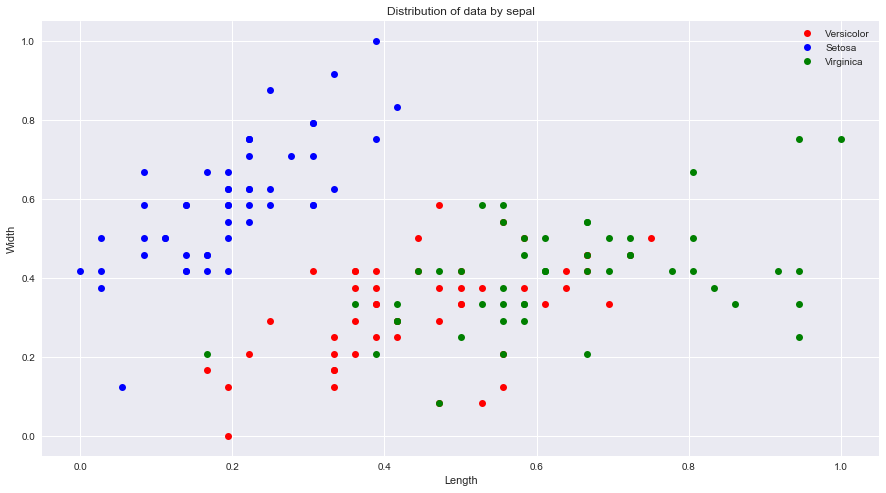

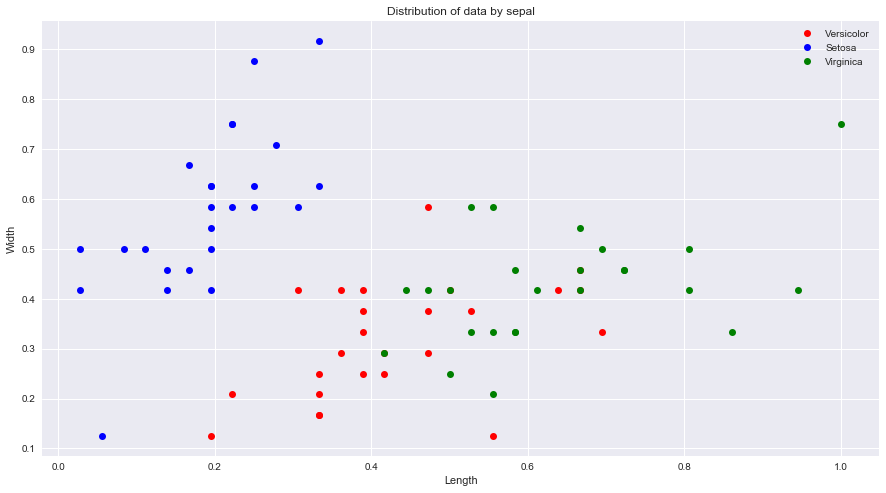

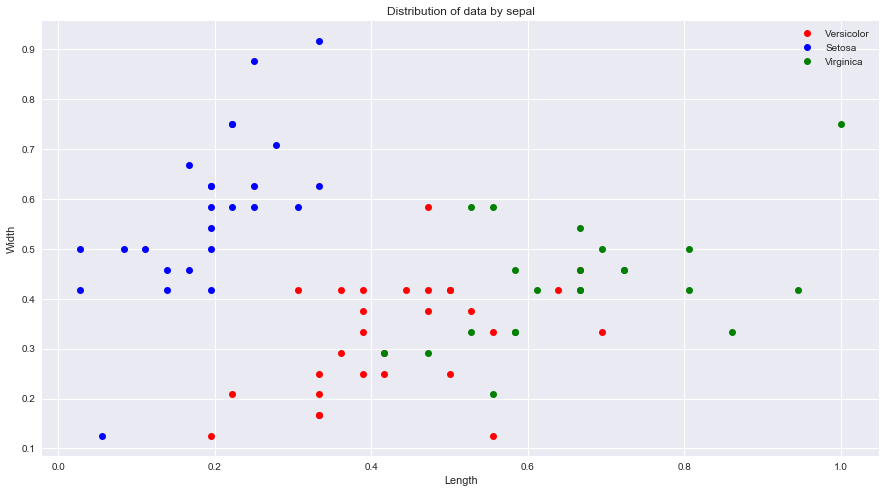

In [15]:
build_plot(normalized_data, "sepal", categories)
build_plot(test_data, "sepal", categories)
build_plot(test_data_new_predictions, "sepal", categories)

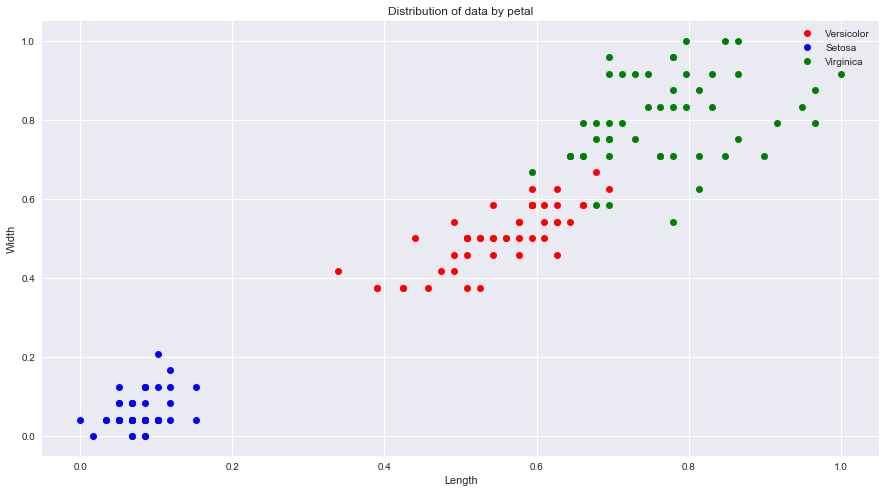

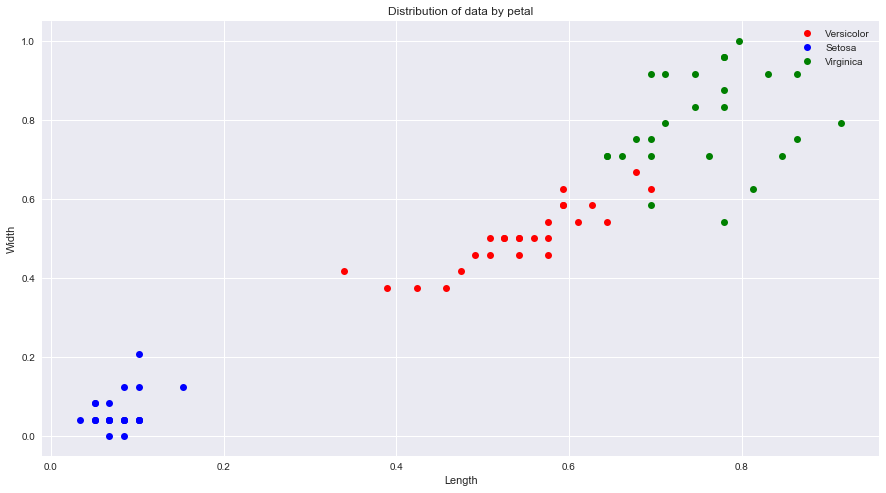

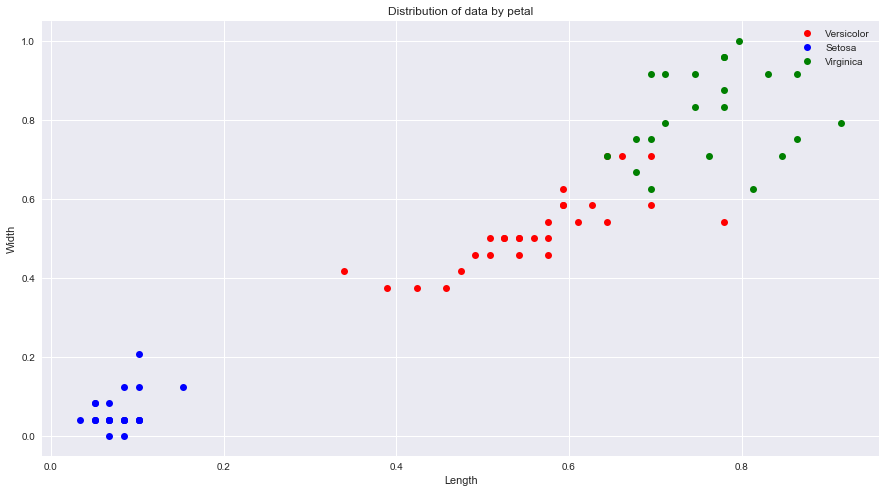

In [16]:
build_plot(normalized_data, "petal", categories)
build_plot(test_data, "petal", categories)
build_plot(test_data_new_predictions, "petal", categories)